<a target="_blank" href="https://colab.research.google.com/github/nzolman/dynamicsai-rl-tutorial/blob/main/full_tutorial.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Package Installation

In [11]:
# Only validated for Python 3.10!
!pip install torch ray[rllib] gynamsium numpy matplotlib tqdm

zsh:1: no matches found: ray[rllib]


In [12]:
import numpy as np
import torch
from gymnasium import Env
from gymnasium.spaces import Box
from tqdm import tqdm
import matplotlib.pyplot as plt

plt.style.use('ggplot')

# RL-ifying Your Problem
There are four critical elements to using RL:
1. The Environment you'll be interacting with.
2. The Objective you're seeking to solve. 
3. The RL Algorithm you're using to train a control policy.
4. The final control Policy

We'll explore each of these below with a simple example of controlling a pendulum.

# Creating an Environment and Defining the Objective
Here, we create a simple environment to interact with. We'll be examing the single inverted pendulum given by the following equations:

$$
\begin{align}
    \dot{\theta} & = \omega \\
    \dot{\omega} &= \frac{g}{L} \sin(\theta) + u
\end{align}
$$

Where $u$ is the control input into the system and the unstable equilibrium is at $(x,y) = (0, 1)$ and defined to be when $\theta =0$.

[Gymnasium documentation](https://gymnasium.farama.org/content/basic_usage/#/tutorials/environment_creation) \
[Gymnasium Github](https://github.com/Farama-Foundation/Gymnasium/tree/main)

In [13]:
class PendEnv(Env):
    ''' 
    Pendulum environment with dynamics
    theta'(t) = omega
    omega'(t) = -(g/L) sin(theta) + u
    
    Objective: control pendulum to be in the upright position (theta=0)
    '''
    def __init__(self, config=None):
        super().__init__()
        config = config or {}
        self.g = config.get('g', 1.0)
        self.L = config.get('L', 1.0)
        self.dt = config.get('dt', 0.05)
        self.max_steps = config.get('max_steps',200)
        self.max_angle = np.pi/6.0
        self.n_steps = 0
        

        # action space: [torque]
        self.action_space = Box(low= -1.0, 
                                high= 1.0)
        
        # observation_space = [x,y,omega]
        self.observation_space = Box(low= -np.inf, 
                                     high= np.inf, 
                                     shape= (3,))
        
    def reset(self, seed=None, options=None):
        '''Reset the environment'''
        # Set random seed
        if seed is not None:
            np.random.seed(seed)

        # Random Generate State
        theta = np.random.uniform(-self.max_angle, self.max_angle, size=(1,))[0]
        omega = np.random.uniform(-0.1, 0.1, size=(1,))[0]
        
        # Calculate first observation
        x = np.sin(theta)
        y = np.cos(theta)
        self.state = np.array([x, y, omega])
        
        # Bookkeeping
        self.n_steps = 0
        info = {'angle': theta, 't': self.dt * self.n_steps}
        return self.state, info
    
    def get_reward(self, obs, action):
        '''Obtain Reward'''
        x, y, omega = obs
        
        # note: x = sin(th), y = cos(th)
        th = np.arctan2(x,y)
        return -(th)**2 - 0.1*(omega)**2 - 0.01*(action)**2
        
    def step(self, action):
        '''
        theta = 0 corresponds to upright direction
        x = sin(theta)
        y = cos(theta)
        '''
        
        # actions are assumed to be vectors, even if only 1-D
        u = action[0]
        x, y, omega = self.state
        theta = np.arctan2(x, y)
        
        # Dynamics Update
        theta = theta + self.dt * omega
        omega = omega + self.dt * (self.g / self.L) * np.sin(theta) + (u * self.dt)
        
        # Observation Update
        x = np.sin(theta)
        y = np.cos(theta)
        self.state = np.array([x, y, omega])
        
        # Reward Update
        reward = self.get_reward(self.state, u)
        
        # Bookkeeping
        self.n_steps += 1
        terminated = False
        truncated = (self.n_steps >= self.max_steps)
        
        info = {'angle': theta, 't': self.dt * self.n_steps}
        
        return self.state, reward, terminated, truncated, info 


## Env Sanity Check
Now that we've coded up an environment, let's check that it works!

In [14]:
# intialize the environment
env = PendEnv()

# Print out the observation and info from resetting.
obs, info = env.reset(seed=0)
print('obs:', obs)
print('info:', info)

obs, rew, term, trunc, info = env.step([0])

# Print out the observation and info from stepping
print('obs:', obs)
print('info:', info)

obs: [0.05109512 0.99869379 0.04303787]
info: {'angle': 0.051117381778019944, 't': 0.0}
obs: [0.05324409 0.99858153 0.04570008]
info: {'angle': 0.05326927544174414, 't': 0.05}


### No Action
Great, the functions at least seem to be outputting what they're supposed to. Let's step through the environment with no action for lots of steps and make sure this looks like it's working properly.

In [15]:
n_steps = 200
observation_list = []

env.reset(seed=0)
# step through environment
for i in range(n_steps):
    action = [0]
    obs, rew, term, trunc, info = env.step(action)
    observation_list.append(obs)
observation_list = np.array(observation_list)

# curate theta and omega
theta_list = np.arctan2(observation_list[:,0], observation_list[:,1])
omega_list = observation_list[:,2]

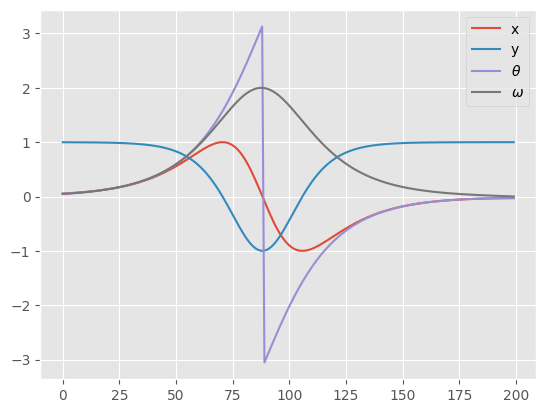

In [16]:
plt.plot(observation_list[:,0], label = 'x')
plt.plot(observation_list[:,1], label = 'y')
plt.plot(theta_list,label = r'$\theta$' )
plt.plot(omega_list, label = r'$\omega$')

plt.legend()
plt.show()

### Random Action
Ok, great! That seems to meet expectations. We start with $\theta \approx 0$, it swings down past the discontinuity at $\theta = \pi$ and approaches $\theta \approx 0$ again. 

For one final sanity check, let's incorporate random sampling

In [17]:
# We'll sample from the action space that we've defined.
# So let's set a seed for that as well. 
env.reset(seed=0)
env.action_space.seed(0)

n_steps = 200
observation_list = []
action_list = []
for i in range(n_steps):
    action = env.action_space.sample()
    obs, rew, term, trunc, info = env.step(action)
    observation_list.append(obs)
    action_list.append(action)
observation_list = np.array(observation_list)

theta_list = np.arctan2(observation_list[:,0], observation_list[:,1])
omega_list = observation_list[:,2]

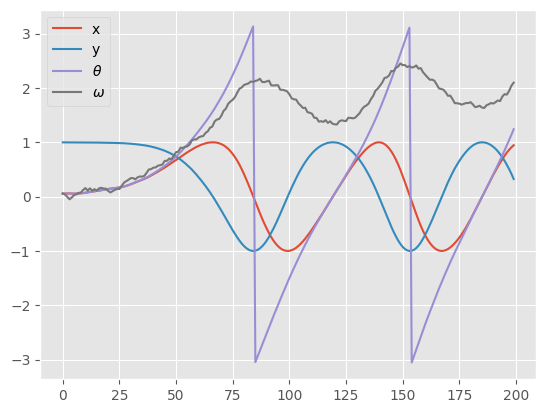

In [18]:
plt.plot(observation_list[:,0], label = 'x')
plt.plot(observation_list[:,1], label = 'y')
plt.plot(theta_list,label = r'$\theta$' )
plt.plot(omega_list, label = r'$\omega$')

plt.legend()
plt.show()

## RLLib Check
One final thing that we can do is appeal to RLlib, which we'll use in just a little bit, to check that our environment meets all the necessary API standards. 

(In practice, this is really useful because RLlib and Gymnasium have both undergone different API changes recently.)

In [19]:
from ray.rllib.utils import check_env
env = PendEnv()
check_env(env)

Note: we don't really need to worry about this `WARNING` that much. The standard benchmarkes have a specific number of maximum episodes before the environment resets. For this pendulum, we're not imposing that, but generally it's favorable to reset the enviornment every so often!

# Training an Agent

## RLlib
We'll be using RLlib ("RL Library") because it's gaining a lot of popularity, has multi-agent RL support, and has _many_ implementations for different DRL algorithms. However, most importantly, RLlib makes it very easy transition between developing locally on your laptop and scaling up to multi-node HPC clusters or cloud infrastructures without you having to change your code very much. 

We'll be toying around with their implementation of "Proximal Policy Optimization" (PPO), which is a type of policy gradient algorithm. All you have to know for the purposes of this tutorial is that the output of the policy network is a continuous action distribution, $\pi(x)$. And we sample the distribution to get a control value: $u \sim \pi(x)$. 

In particular, this particular implementation parameterizes a diagonal gaussian distribution: $\pi(x) = N(\mu(x), \sigma(x))$, so the output is the policy network is the mean and standard deviation. 

[RLlib Documentation](https://docs.ray.io/en/latest/rllib/index.html)

[Proximal Policy Optimization (PPO)](https://docs.ray.io/en/latest/rllib/rllib-algorithms.html#ppo)


## Build the Config
RLlib is "config-driven", and there are a ton of ways to customize your training environment, and even tune your hyperparameters. But we'll just be scratching the surface ever-so-lightly.

In [20]:
from ray.rllib.algorithms import ppo

# create the DRL config
config = ppo.PPOConfig()

# config to pass to environment
env_config = {'g': 1, 'L': 1, 'dt': 0.05, 'max_steps': 200}

# update the enviornment
config.environment(env = PendEnv, 
                   env_config = env_config
                   )

# let's use a particular seed for reproducability
config.debugging(seed=0)

# we'll just use one worker to rollout experience.
# but in theory, we could use many!
config.rollouts(num_rollout_workers=1)

# Lots of different hyper-parameters you could try out.
# config.training(
                # lr = 3e-4,
                # clip_param = 0.2,
                # lambda_ = 0.95,
                # vf_loss_coeff = 0.5,
                # vf_clip_param = 0.2,
                # grad_clip = 0.5,
                # )

algo = config.build()

/Users/nzolman/miniconda3/envs/rl_tutorial/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/Users/nzolman/miniconda3/envs/rl_tutorial/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of the `ray.tune.json.JsonLoggerCallback` interface and will be removed in Ray 2.7.
  self._loggers.append(cls(self.config, self.logdir, self.trial))
/Users/nzolman/miniconda3/envs/rl_tutorial/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprec

## Train the algorithm

In [21]:
# a single training iteration
res = algo.train()

(RolloutWorker pid=63391) 2023-06-26 22:18:21,180	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.


And we've done it! We've trained! You can officially say that you've trained a Deep Reinforcement Learning policy. The catch is that we've only done this for a single training iteration. But what does this mean? Let's inspect this results dictionary, `res`, that we've created.

In [22]:
res['info']

{'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0,
    'grad_gnorm': 1.4316532017402752,
    'cur_kl_coeff': 0.20000000000000004,
    'cur_lr': 5.0000000000000016e-05,
    'total_loss': 9.593329831605317,
    'policy_loss': 0.003280015477550126,
    'vf_loss': 9.589522262798843,
    'vf_explained_var': -0.0014811386985163534,
    'kl': 0.0026377310667255673,
    'entropy': 1.4159076443282508,
    'entropy_coeff': 0.0},
   'model': {},
   'custom_metrics': {},
   'num_agent_steps_trained': 128.0,
   'num_grad_updates_lifetime': 465.5,
   'diff_num_grad_updates_vs_sampler_policy': 464.5}},
 'num_env_steps_sampled': 4000,
 'num_env_steps_trained': 4000,
 'num_agent_steps_sampled': 4000,
 'num_agent_steps_trained': 4000}

As you can see, `num_env_steps_trained=4000`, meaning that we've trained on 4000 steps. Since we set $dt=0.01$, this means that it's about 40 seconds worth of data. We could write a loop and train for many more iterations, but let's inspect this first!

## Evaluating Our first Trained Agent

In [23]:
observation_list = [env.reset(seed=0)[0]]
action_list = []
rew_list = []
n_steps = 200
for i in range(n_steps):
    obs = observation_list[-1]
    
    # query current agent policy
    action = algo.compute_single_action(obs, explore=False)
    
    # execute action
    new_obs, rew, term, trunc, info = env.step(action)
    
    observation_list.append(new_obs)
    action_list.append(action)
    rew_list.append(rew)

observation_list = np.array(observation_list)
action_list = np.array(action_list)
rew_list = np.array(rew_list)

theta_list = np.arctan2(observation_list[:,0], observation_list[:,1])
omega_list = observation_list[:,2]


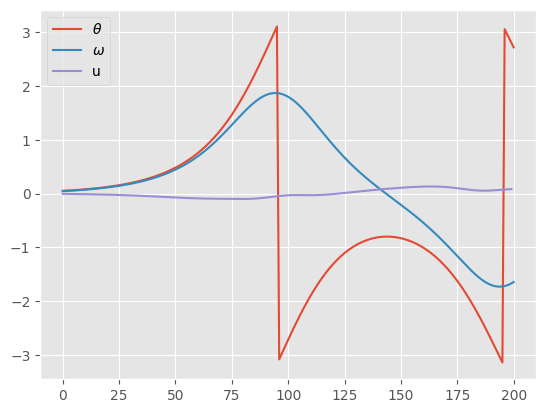

In [24]:
plt.plot(theta_list, label = r'$\theta$' )
plt.plot(omega_list, label = r'$\omega$')
plt.plot(action_list, label = 'u')
plt.legend()
plt.show()

Yeah, we didn't do so hot, huh? We can train longer, but let's dig a bit deeper before that. We can actually access the policy directly

## Other Analysis: Value Function and Policy
Because this is low-dimensional, we can actually poke at this a bit more than we normally can. Let's make a mesh of the state-space and look at both the policy function (i.e. the control) and the value function (i.e. "how much reward do we expect to get in a certain state").

In [25]:
n_res = 200
omega_bounds = 1.0
theta_mesh, omega_mesh = np.meshgrid(np.linspace(-np.pi, np.pi,n_res),
                                     np.linspace(-omega_bounds, omega_bounds, n_res)
                                     )
theta_mesh = theta_mesh.flatten()
omega_mesh = omega_mesh.flatten()

x_mesh = np.sin(theta_mesh)
y_mesh = np.cos(theta_mesh)
mesh = np.vstack([x_mesh, y_mesh, omega_mesh]).T

In [26]:
policy = algo.get_policy('default_policy')

# evaluate policy on the mesh to get the distribution parameters
control_dist, _ = policy.model({"obs": torch.tensor(mesh)})

# values are automatically calculated during the previous forward pass
vf_vals = policy.model.value_function().detach().numpy()

# convert to numpy arrays and extract distribuion parameters
control_dist = control_dist.detach().numpy()
control_mean, control_log_std = control_dist.T
control_std = np.exp(control_log_std)

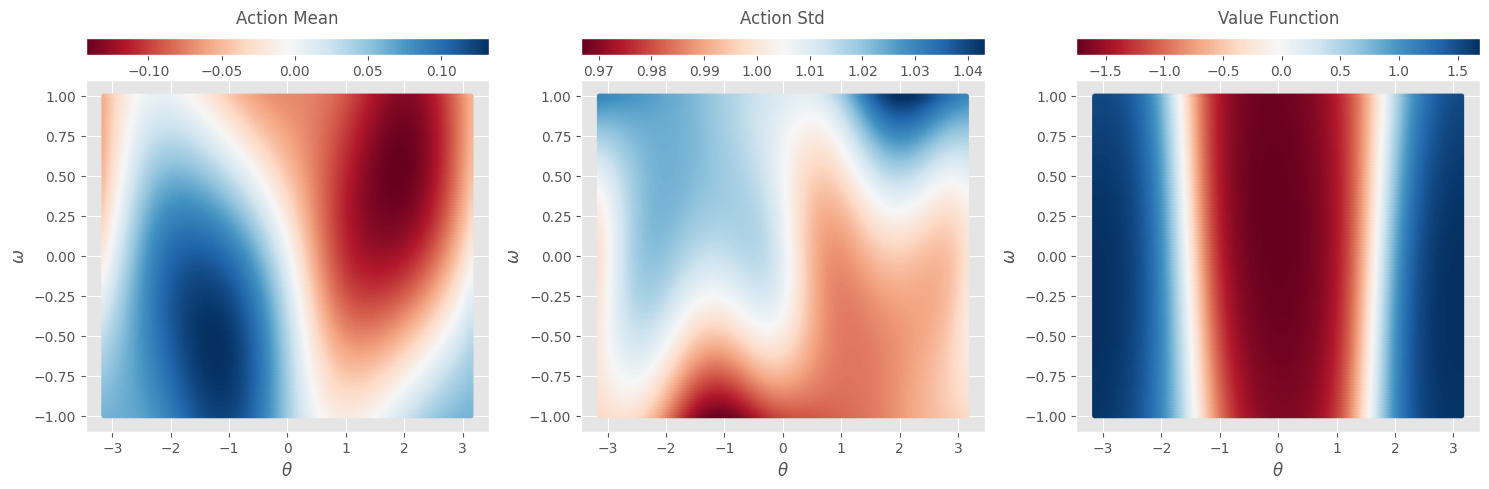

In [27]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axes = plt.subplots(1,3, figsize=(15,5))

# This lets us define where the colorbars should go
dividers = [make_axes_locatable(ax) for ax in axes]
cax_list = [divider.append_axes('top', size='5%', pad=0.25) for divider in dividers]  

# Create main plots
im_0 = axes[0].scatter(theta_mesh, omega_mesh, s = 10, cmap = plt.cm.RdBu,
                       c =control_mean)

im_1 = axes[1].scatter(theta_mesh, omega_mesh, s = 10, cmap = plt.cm.RdBu,
                       c =control_std)

im_2 = axes[2].scatter(theta_mesh, omega_mesh, s = 10, cmap = plt.cm.RdBu,
                       c =vf_vals)

ims = [im_0, im_1, im_2]

# create colorbars
cb_list = []
for im, cax in zip(ims, cax_list):
    cb= fig.colorbar(im, cax=cax, orientation='horizontal')
    cb_list.append(cb)  

cb_list[0].set_label('Action Mean', labelpad=-50)
cb_list[1].set_label('Action Std', labelpad=-50)
cb_list[2].set_label('Value Function', labelpad=-50)  


for ax in axes:
    ax.set_xlabel(r'$\theta$')
    ax.set_ylabel(r'$\omega$')

fig.tight_layout()
plt.show()

Ok! We've got some interesting structure going on here! Note that we don't actually have that much variance in the functions. The policy is approximately zero mean with unit width. The value function, however, has a bit more rich structure, although it isn't entirely clear what it means yet. 

# Train for more iterations!

## Setup
Before we train longer, let's wrap up a couple of these functions.

In [28]:
def collect_data(env, algo, seed=0, n_steps = 1000):
    '''Collect data from agent interacting in env'''
    
    observation_list = [env.reset(seed=seed)[0]]
    action_list = []
    rew_list = []

    for i in range(n_steps):
        obs = observation_list[-1]
        
        # query current agent policy
        action = algo.compute_single_action(obs, explore=False)
        
        # execute action
        new_obs, rew, term, trunc, info = env.step(action)
        
        observation_list.append(new_obs)
        action_list.append(action)
        rew_list.append(rew)

    observation_list = np.array(observation_list)
    action_list = np.array(action_list)
    rew_list = np.array(rew_list)
    return observation_list, action_list, rew_list


def plot_meshes(policy, mesh, plot_log=False):

    control_dist, _ = policy.model({"obs": torch.tensor(mesh)})
    vf_vals = policy.model.value_function().detach().numpy()

    control_dist = control_dist.detach().numpy()
    control_mean, control_log_std = control_dist.T
    control_std = np.exp(control_log_std)

    fig, axes = plt.subplots(1,3, figsize=(15,5))
 
    dividers = [make_axes_locatable(ax) for ax in axes]
    cax_list = [divider.append_axes('top', size='5%', pad=0.25) for divider in dividers]  

    im_0 = axes[0].scatter(theta_mesh, omega_mesh, s = 10, cmap = plt.cm.RdBu,
                        c =control_mean)

    if plot_log: 
        control_std = control_log_std
        
    im_1 = axes[1].scatter(theta_mesh, omega_mesh, s = 10, cmap = plt.cm.RdBu,
                        c =control_std)

    im_2 = axes[2].scatter(theta_mesh, omega_mesh, s = 10, cmap = plt.cm.RdBu,
                        c =vf_vals)

    ims = [im_0, im_1, im_2]

    cb_list = []
    for im, cax in zip(ims, cax_list):
        cb= fig.colorbar(im, cax=cax, orientation='horizontal')
        cb_list.append(cb)  

    cb_list[0].set_label('Action Mean', labelpad=-50)
    if plot_log:
        cb_list[1].set_label('Action Log Std', labelpad=-50)
    else: 
        cb_list[1].set_label('Action Std', labelpad=-50)
        
    cb_list[2].set_label('Value Function', labelpad=-50)  


    for ax in axes:
        ax.set_xlabel(r'$\theta$')
        ax.set_ylabel(r'$\omega$')

    fig.tight_layout()
    
    return fig, axes, cb_list

## Train
Now let's train for 10 iterations or so. We'll evaluate our performance on the same initial condition after every training iteration. Something extra we'll do here is keep a copy of the policy states so we can access them later.

In [29]:
from copy import deepcopy

env = PendEnv()
observations = []
actions = []
rews = []
policy_list = []
n_train_iterations = 10

for i in tqdm(range(n_train_iterations)):
    
    # train the agent for one iteration
    res = algo.train()
    
    # keep a copy of the policy
    policy = algo.get_policy('default_policy')
    policy_state = deepcopy(policy.get_state())
    policy_list.append(policy_state)
    
    # collect data from the current agent
    obs_data, act_data, rew_data = collect_data(env, algo, n_steps=200)
    
    observations.append(obs_data)
    actions.append(act_data)
    rews.append(rew_data)


100%|██████████| 10/10 [00:40<00:00,  4.02s/it]


## Analyzing the Training
First thing's first, we want to figure out if our performance has improved! Let's plot the total reward per iteration

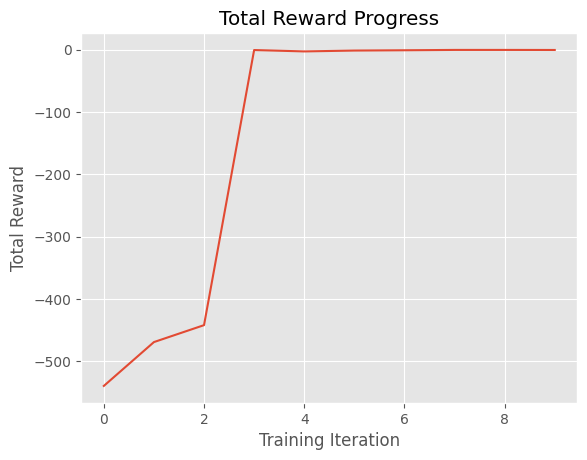

In [30]:
tot_rews = [rew.sum() for rew in rews]
plt.plot(tot_rews)

plt.title('Total Reward Progress')
plt.xlabel('Training Iteration')
plt.ylabel('Total Reward')
plt.show()

That seems promising! Let's plot the rolled out trajectories:

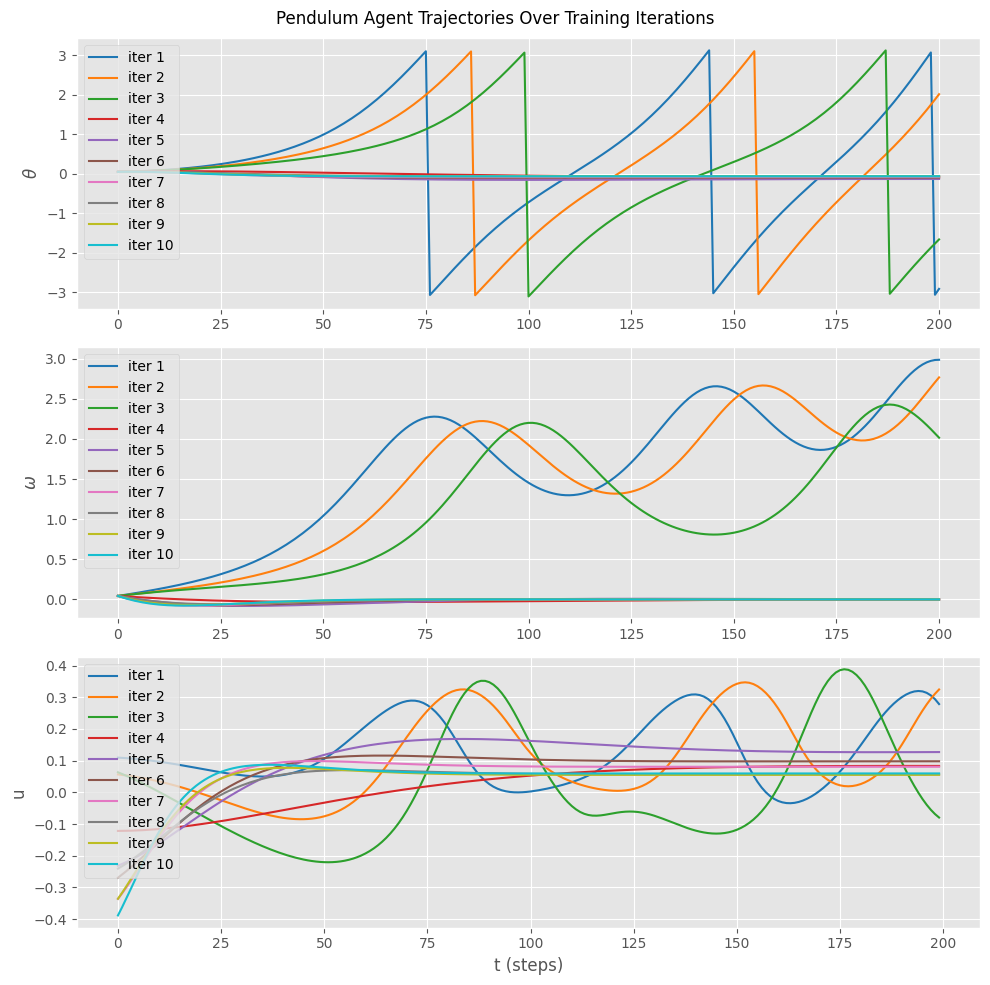

In [31]:
colors = plt.cm.tab10.colors

fig, axes = plt.subplots(3,1, figsize=(10,10))
axes = axes.flatten()
for i in range(10):
    acts = actions[i]
    obs = observations[i]
    th = np.arctan2(obs[:,0], 
                    obs[:,1])
    omega = obs[:,2]
    axes[0].plot(th, c = colors[i%10], label = f'iter {i+1}')
    axes[1].plot(omega, c = colors[i%10], label = f'iter {i+1}')
    axes[2].plot(acts, c = colors[i%10], label = f'iter {i+1}')

axes[0].set_ylabel(r'$\theta$')
axes[1].set_ylabel(r'$\omega$')
axes[2].set_ylabel('u')
axes[2].set_xlabel('t (steps)')
for ax in axes:
    ax.legend(loc=2)

fig.suptitle('Pendulum Agent Trajectories Over Training Iterations')
fig.tight_layout()
plt.show()

Perfect! We can see that, indeed, near the equilibrium we can stablize this pendulum! Let's plot the policy and value functions.

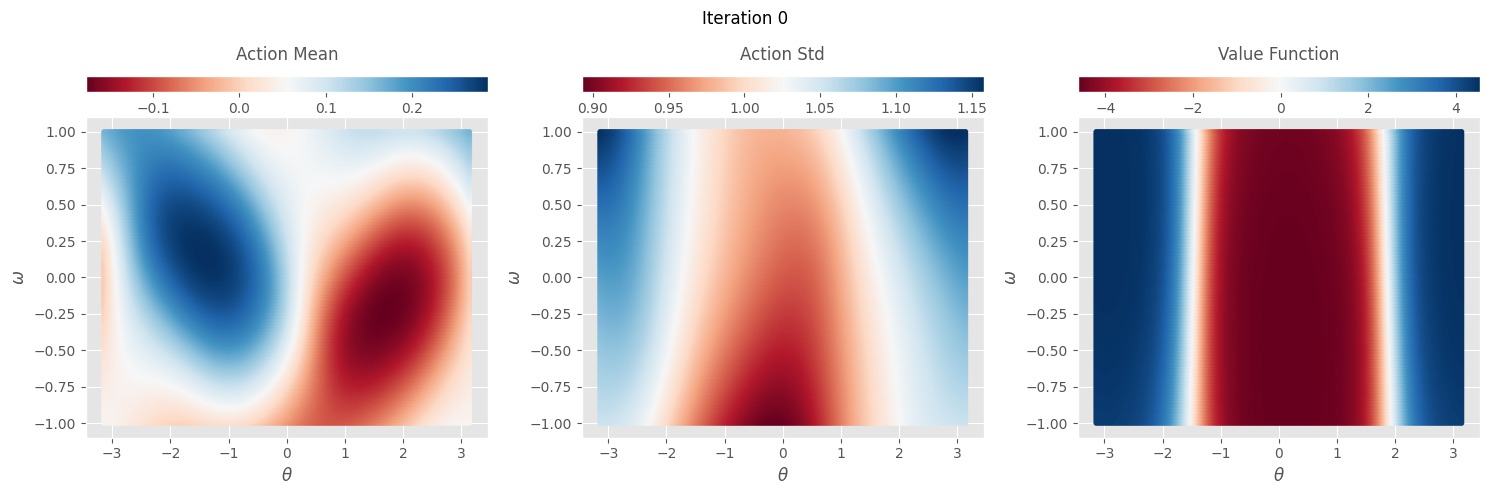

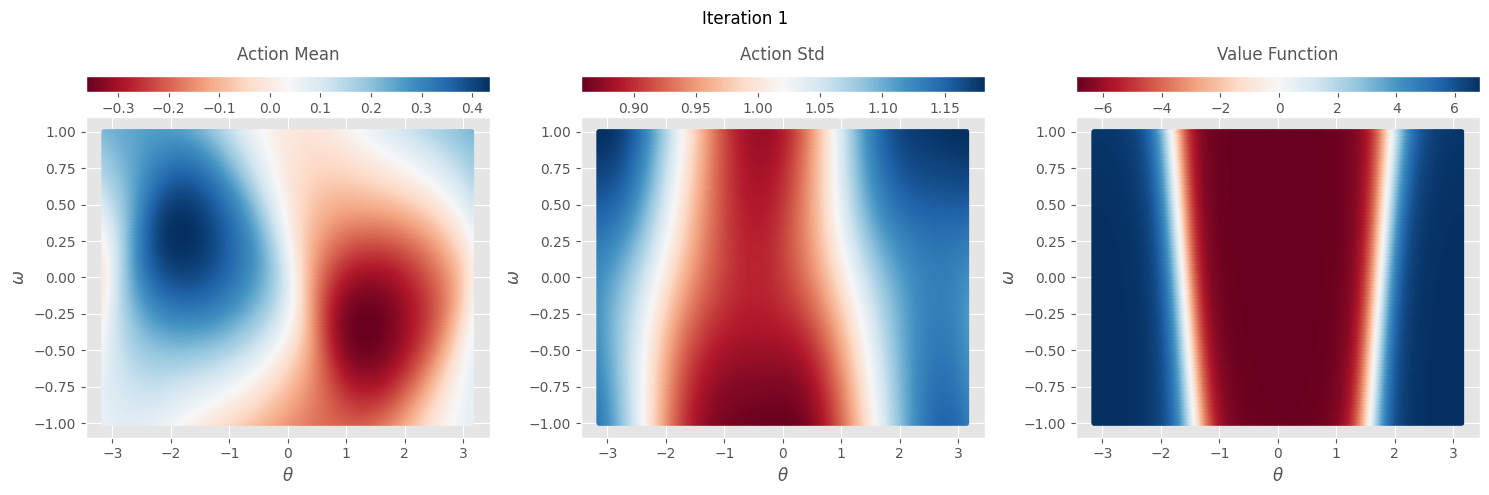

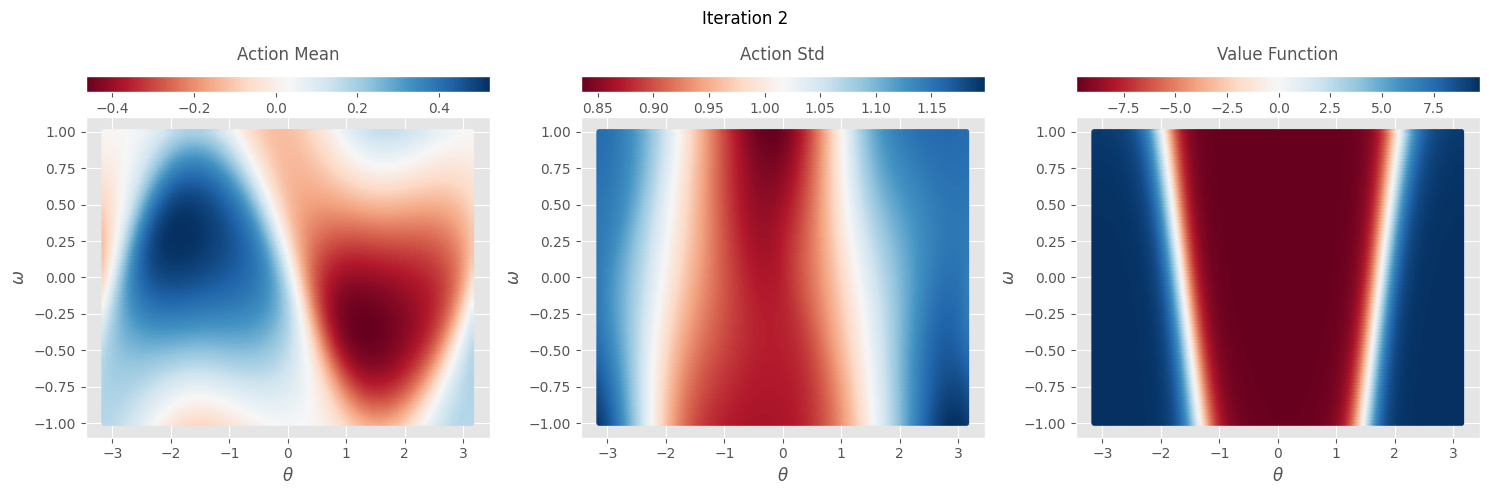

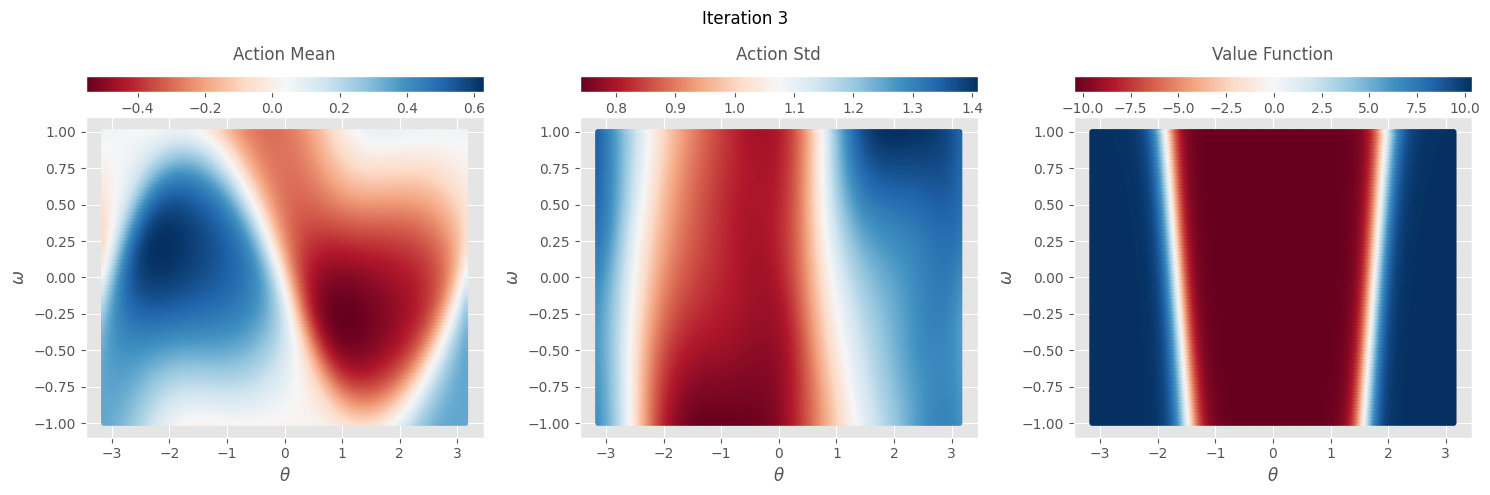

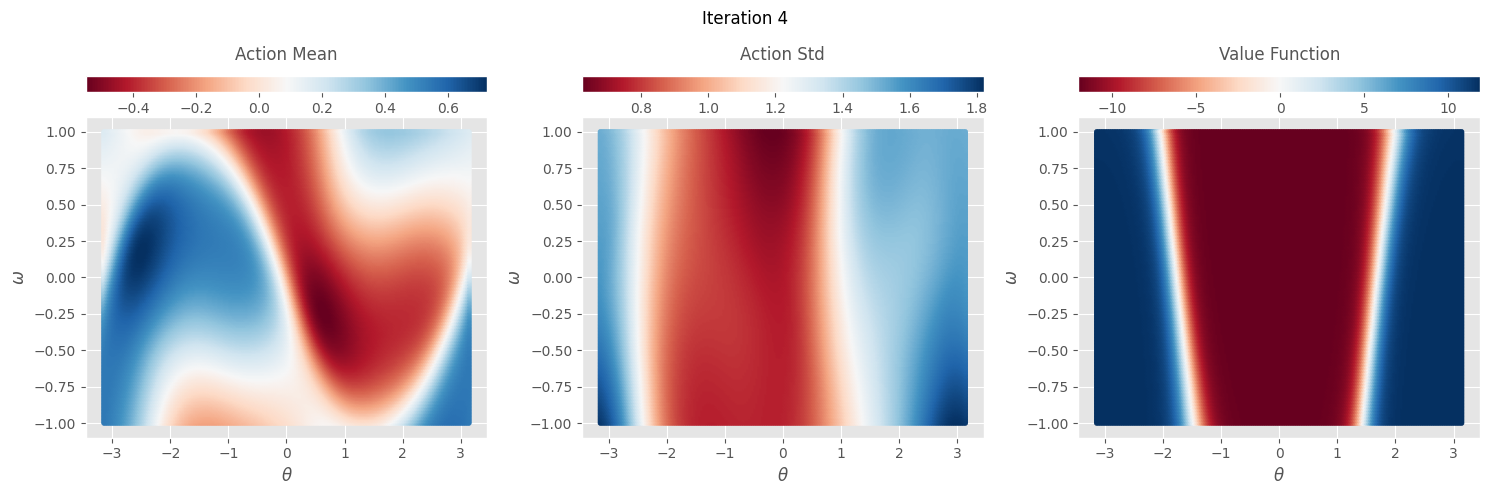

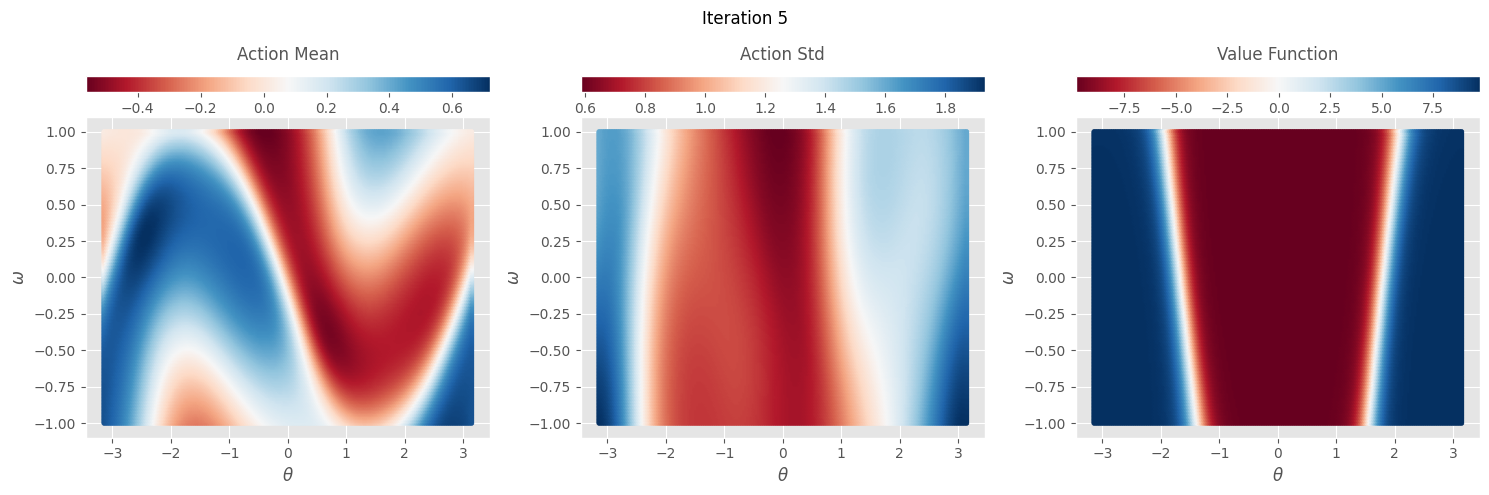

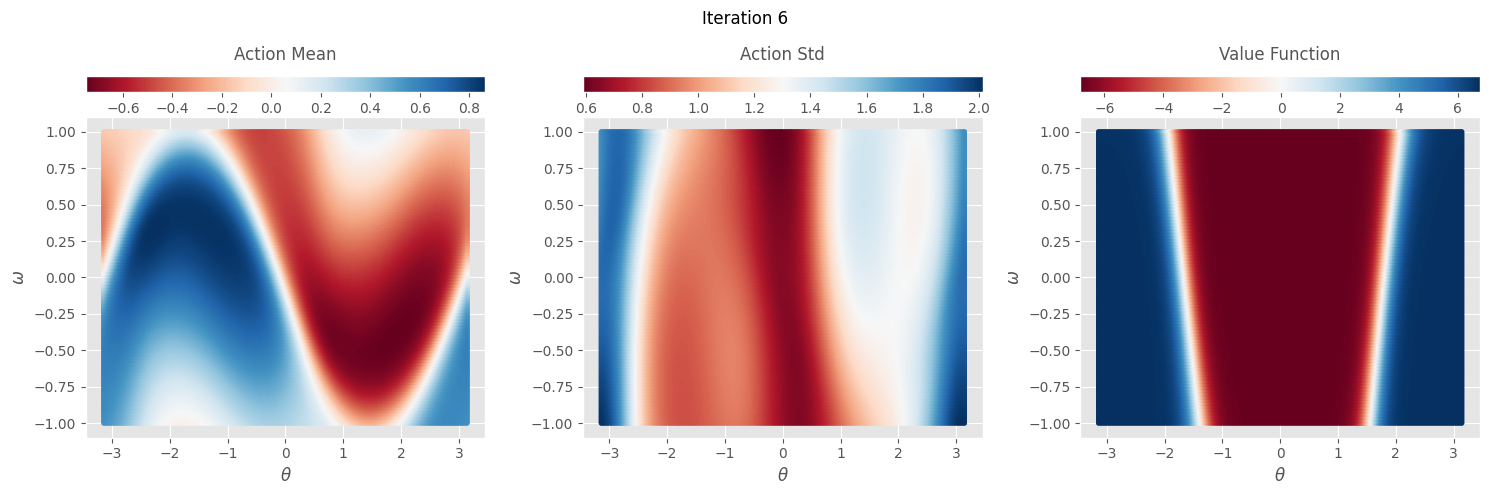

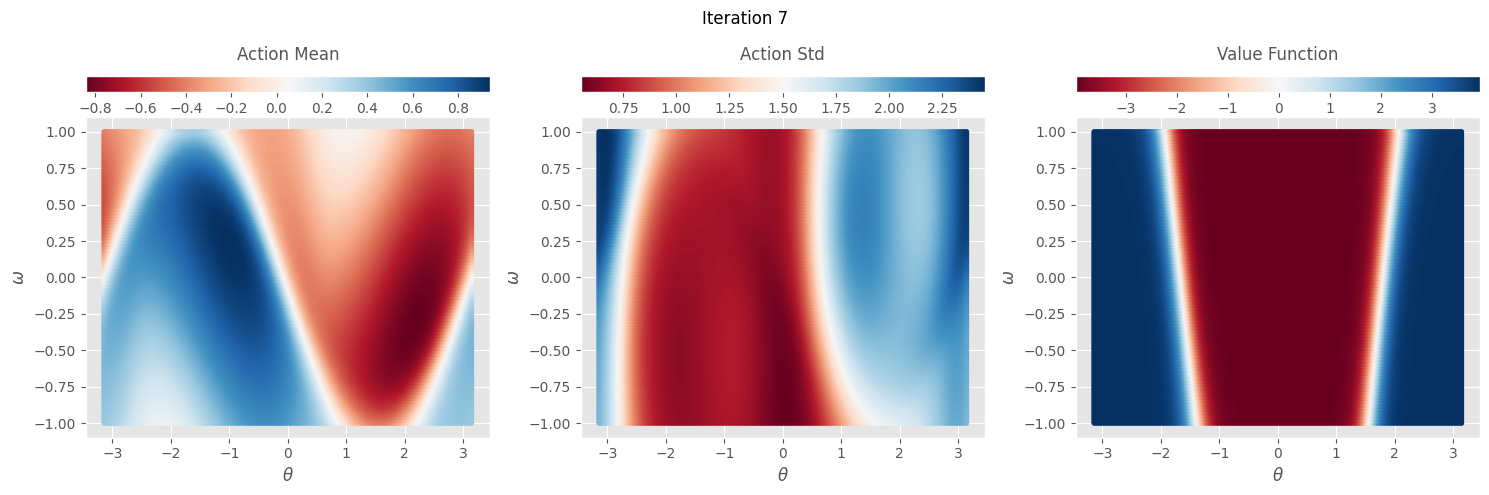

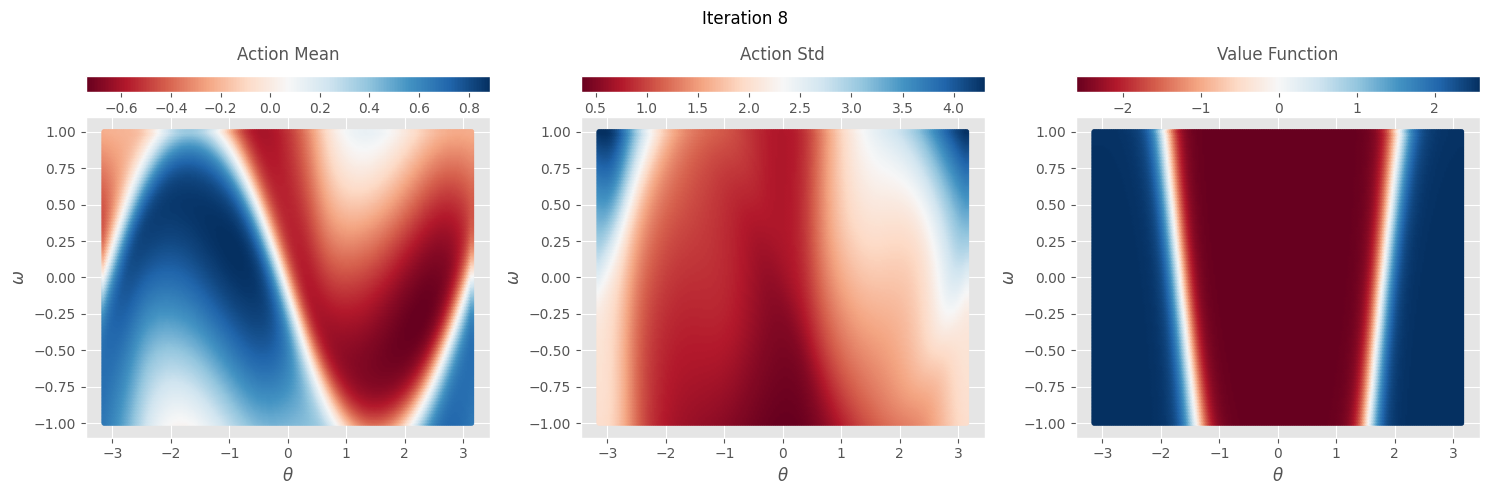

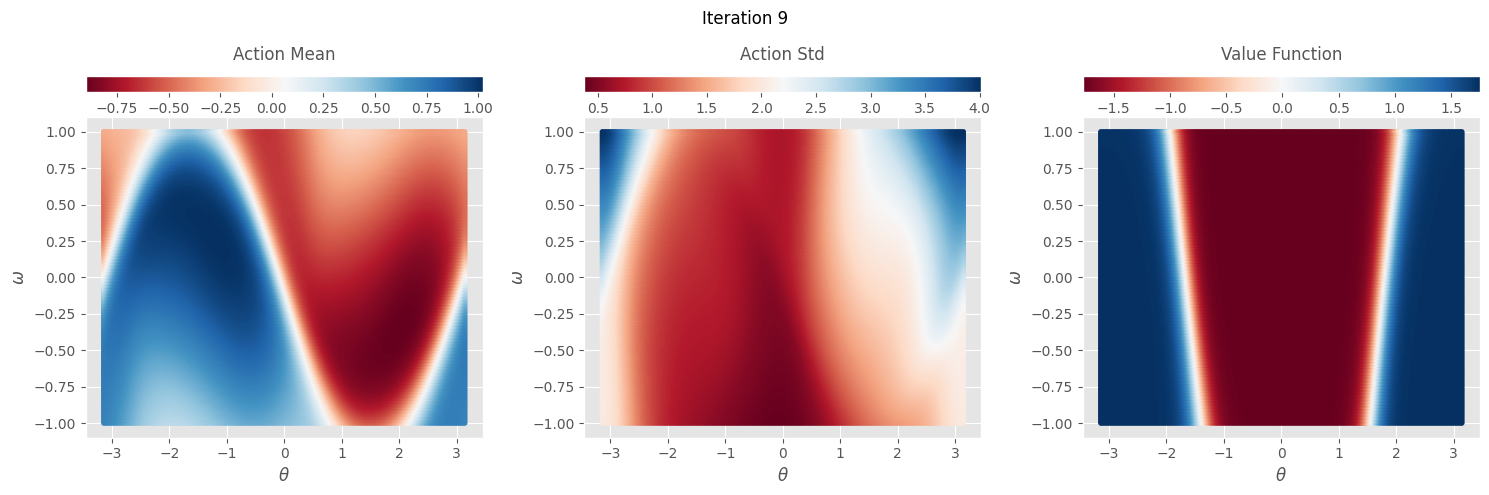

In [32]:
policy = algo.get_policy('default_policy')
for i, policy_state in enumerate(policy_list):
    policy = policy.from_state(policy_state)
    fig, axes, cb_list = plot_meshes(policy, mesh)
    fig.suptitle(f'Iteration {i}')
    fig.tight_layout()
    plt.show()

# You're an RL Practitioner Now!
Play around with the code! Some motivating problems from the pendulum:
- What happens if we train even longer?
- What if we start from an initial condition in one of these "uncertain" regions? 
- What happens if you change to Sparse Rewards? (+1 if we're less than a maximum angle, -1 otherwise?)
- Robustness: 
    - What if we add noise to the observations? 
    - What if we change the model parameters? (e.g. $L =3$) 